In [10]:
import torch
from torch import nn

GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg)
                for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias= False)
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, nomalized_shape,eps = 1e-5):
        super().__init__()
    def forward(self, x):
        return x



In [11]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
text1 = "Every effort moves you"
text2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))

batch = torch.stack(batch,dim=0)
print(batch)

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits.shape)
print(logits)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


In [12]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("mean", mean)
print("var", var)

out_norm = (out - mean) / torch.sqrt(var)
mean_norm = out_norm.mean(dim=-1, keepdim=True)
var_norm = out_norm.var(dim=-1, keepdim=True)

print("Normalized layer outputs\n", out_norm)
print("mean\n", mean_norm)
print("var\n", var_norm)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
mean tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
Normalized layer outputs
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
var
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [13]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return norm_x * self.scale + self.shift
    
ln = LayerNorm(5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True)
print("LayerNorm output\n", out_ln)
print("LayerNorm mean\n", mean)
print("LayerNorm var\n", var)



LayerNorm output
 tensor([[ 0.4945,  0.9564, -0.0200,  0.2375, -1.6685],
        [ 0.8127, -1.2313, -0.8554,  1.0110,  0.2630]], grad_fn=<AddBackward0>)
LayerNorm mean
 tensor([[-1.4901e-08],
        [ 2.3842e-08]], grad_fn=<MeanBackward1>)
LayerNorm var
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


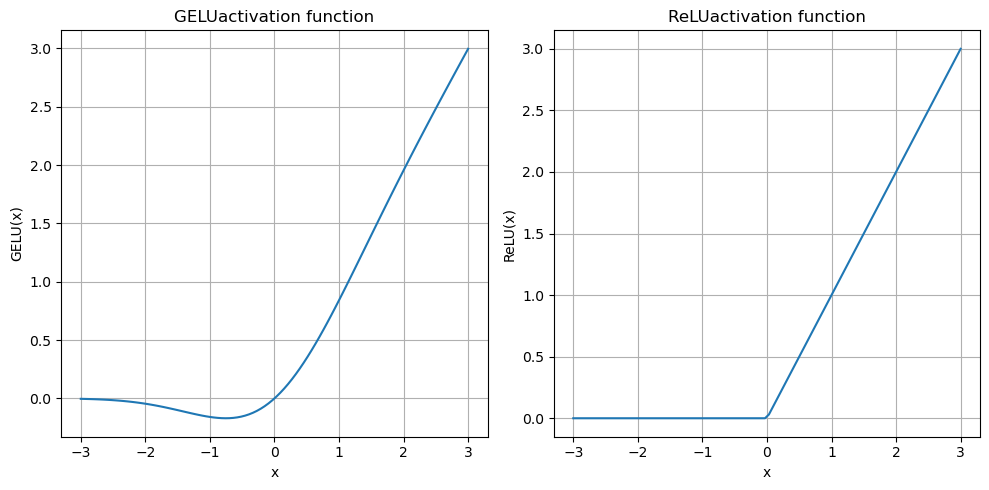

In [14]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.sqrt(torch.tensor(2.0 / torch.pi))
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(self.a * (x + 0.044715 * torch.pow(x, 3))))

import matplotlib.pyplot as plt

gelu,relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu = gelu(x)
y_relu = relu(x)
plt.figure(figsize=(10, 5))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"])):
    plt.subplot(1, 2, i + 1)
    plt.plot(x, y)
    plt.title(f"{label}activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid()
plt.tight_layout()
plt.show()



In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)

ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2, 5, GPT_CONFIG_124M["emb_dim"])
out_ffn = ffn(x)
print("FeedForward output shape:", out_ffn.shape)

FeedForward output shape: torch.Size([2, 5, 768])


In [16]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_size, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_size[0], layer_size[1]), GELU()),
            nn.Sequential(nn.Linear(layer_size[1], layer_size[2]), GELU()),
            nn.Sequential(nn.Linear(layer_size[2], layer_size[3]), GELU()),
            nn.Sequential(nn.Linear(layer_size[3], layer_size[4]), GELU()),
            nn.Sequential(nn.Linear(layer_size[4], layer_size[5]), GELU()),
            nn.Sequential(nn.Linear(layer_size[5], layer_size[6]), GELU())
        ])
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [ ]:
from functions import MutiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MutiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"],
        )
        self.ffn = FeedForward(cfg)
        self.ln1 = LayerNorm(cfg["emb_dim"])
        self.ln2 = LayerNorm(cfg["emb_dim"])
        self.drop = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        shortcut = x
        x = self.ln1(x)
        x = self.attn(x)
        x = self.drop(x)
        x = x + shortcut
        shortcut = x
        x = self.ln2(x)
        x = self.ffn(x)
        x = self.drop(x)
        x = x + shortcut
        return x

torch.manual_seed(123)
x = torch.rand(2,4, GPT_CONFIG_124M["emb_dim"])
block = TransformerBlock(GPT_CONFIG_124M)
out_block = block(x)
print("input_shape:", x.shape)
print("output_shape:", out_block.shape)

tensor([0.9366, 1.4690, 1.4626, 0.8368, 0.7050, 1.0755])
tensor([0.1444, 0.2265, 0.2255, 0.1290, 0.1087, 0.1658])
Sum of attention weights: tensor(1.)
Attention weights after softmax: tensor([0.1381, 0.2351, 0.2336, 0.1250, 0.1095, 0.1586])
Sum of attention weights after softmax: tensor(1.0000)
Context vector: tensor([0.4416, 0.6507, 0.5624])
All scores (dot products):
tensor([[0.9995, 0.9366, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9366, 1.4690, 1.4626, 0.8368, 0.7050, 1.0755],
        [0.9422, 1.4626, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8368, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7050, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0755, 1.0605, 0.6565, 0.2935, 0.9450]])
All attention weights after softmax:
tensor([[0.2106, 0.1977, 0.1989, 0.1247, 0.1225, 0.1457],
        [0.1381, 0.2351, 0.2336, 0.1250, 0.1095, 0.1586],
        [0.1394, 0.2346, 0.2333, 0.1246, 0.1111, 0.1569],
        [0.1437, 0.2063, 0.2048, 0.1464, 0.1265, 0.1723],
        [0

NameError: name 'nn' is not defined

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(batch)

print("GPTModel output shape:", logits.shape)
print("GPTModel logits:\n", logits)


total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in GPTModel: {total_params:,}")
print("Token embedding shape:", model.tok_emb.weight.shape)
print("Positional embedding shape:", model.pos_emb.weight.shape)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
GPTModel output shape: torch.Size([2, 4, 50257])
GPTModel logits:
 tensor([[[ 0.1381,  0.0079, -0.1957,  ..., -0.0222, -0.1062,  0.1717],
         [ 0.3867, -0.8400, -0.6558,  ..., -0.5162,  0.2362, -0.3349],
         [ 0.6985, -0.1826, -0.1634,  ...,  0.1472, -0.6503, -0.0054],
         [-0.4288,  0.1670, -0.1262,  ...,  1.1571,  0.5297, -0.5542]],

        [[ 0.1095, -0.2890, -0.1463,  ..., -0.0557,  0.2907, -0.2818],
         [ 0.0884, -0.3545, -0.3524,  ...,  1.2921,  0.0050,  0.1902],
         [ 0.6092,  0.4702, -0.4093,  ...,  0.7682,  0.3781, -0.1968],
         [-0.0608, -0.0739,  0.4747,  ...,  1.2458, -0.3834,  0.0612]]],
       grad_fn=<UnsafeViewBackward0>)
Total parameters in GPTModel: 163,009,536
Token embedding shape: torch.Size([50257, 768])
Positional embedding shape: torch.Size([1024, 768])


In [ ]:
def geneate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Keep only the last context_size tokens
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # Get the logits for the last token
        probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
        idx_next = torch.argmax(probs, dim=-1,keepdim=True)  # Sample from the distribution
        idx = torch.cat((idx, idx_next), dim=1)  # Append the new token to the sequence
    return idx

start_content = "Every effort moves you"
encoded_start = tokenizer.encode(start_content)
encoded_start = torch.tensor(encoded_start).unsqueeze(0)  # Add batch dimension
print("Encoded start content:", encoded_start)
model.eval()

out = geneate_text_simple(model, encoded_start, max_new_tokens=20, context_size=GPT_CONFIG_124M["context_length"])
print("Generated text indices:", out)
print("Generated text shape:", out.shape)
decoded_text = tokenizer.decode(out[0].tolist())
print("Generated text:", decoded_text)
print("Generated text length:", len(decoded_text))

Encoded start content: tensor([[6109, 3626, 6100,  345]])
Generated text indices: tensor([[ 6109,  3626,  6100,   345, 45642,  7639, 17422, 40117, 18958,  6071,
          1916, 17225, 37636, 35893, 29938, 31557, 18644, 36443, 32194, 34770,
         19005, 47396, 12091, 37732]])
Generated text shape: torch.Size([1, 24])
Generated text: Every effort moves you detractorsjo charter Parametersochem forthmberigmcivil Wah neoc tv upward TulsaSah373 zombies514 Jane Writers
Generated text length: 132
